## PCA Task

 Perform PCA-based anomaly detection.

###  Load the data

 

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import decomposition
from helper_functions.pca_helper_functions import *
from helper_functions.comparison_helper_functions import *
%matplotlib inline


# Load the datasets from the saved numpy arrays in the Familiarization task
X = np.load('./data/train_data.npy')
y = np.load('./data/actual_train_labels.npy')
X_test = np.load('./test_data.npy')


# Seperate the two training datasets
# X1, y1 = training data and labels 1 (normal behaviour)
# X2, y2 = training data and labels 2 (attacks present)
num = 8761
X1 = X[:num]
X2 = X[num:]
y1 = y[:num]
y2 = y[num:]

# Check that everything is there
print("Training dataset shape: ", X.shape)
print("Test dataset shape: ", X_test.shape)
print("Number of attacks: ", np.sum(y==1))


Training dataset shape:  (12938, 40)
Test dataset shape:  (2089, 40)
Number of attacks:  492


### Normalize the train data to have zero mean to apply PCA
- Useful visualizations: that show the number of components that capture the majority of the variance.  
   

In [2]:
#Normalize - apply model 
normalize = StandardScaler()
n_data = normalize.fit_transform(X1)

model = PCA( n_components= X1.shape[1])
p_data = model.fit_transform(n_data)
r_data = model.inverse_transform(p_data)

#print cumulative variance 
cummulative_variance=model.explained_variance_ratio_.cumsum()
print(cummulative_variance)

[0.19612305 0.31662018 0.43230526 0.52360839 0.58867985 0.65065948
 0.70066975 0.75053028 0.7890944  0.82060956 0.85005591 0.87476162
 0.8990998  0.92122835 0.94233345 0.96109835 0.97773725 0.98848145
 0.99497675 0.99681129 0.99778659 0.99848837 0.9990731  0.99941448
 0.9996421  0.99982645 0.99988703 0.99993342 0.99995854 0.99997081
 0.99997846 0.99998583 0.9999908  0.99999567 0.99999846 0.99999997
 1.         1.         1.         1.        ]


- Visualize the variance to determine the number of principal components to use.

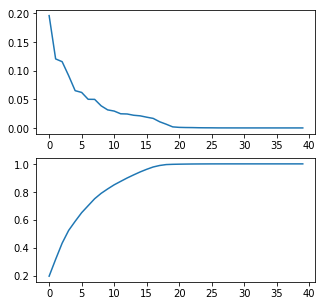

In [3]:
#plot the variance ratio and the cumulative variance
fig, (ax1, ax2) = plt.subplots(2, 1, figsize =[5,5] )
ax1.plot(model.explained_variance_ratio_)
ax2.plot(model.explained_variance_ratio_.cumsum())

### Find the number of principal components  that capture the majority of the variance 
- We selected the variance = 95% captured by 16 components, because from the figures above we observed that 15 or 16 principal components could capture the majority of the variance in the data.  

In [5]:
eigenv = model.explained_variance_

#function that determines the number of components 
num  = optimal_components(eigenv, 0.95)
print("Number of components:", num)

Number of components: 16


- Apply PCA with the selected number of components to the train data and compute the residuals

In [6]:
#fit and transform the new model and construct the inverse matrix.

pca = PCA(n_components= num)
np_data = pca.fit_transform(n_data)
rec_data = pca.inverse_transform(np_data)
print(np_data.shape)
print('{:0.0%} of variance is captured'.format(sum(pca.explained_variance_ratio_)))

(8761, 16)
96% of variance is captured


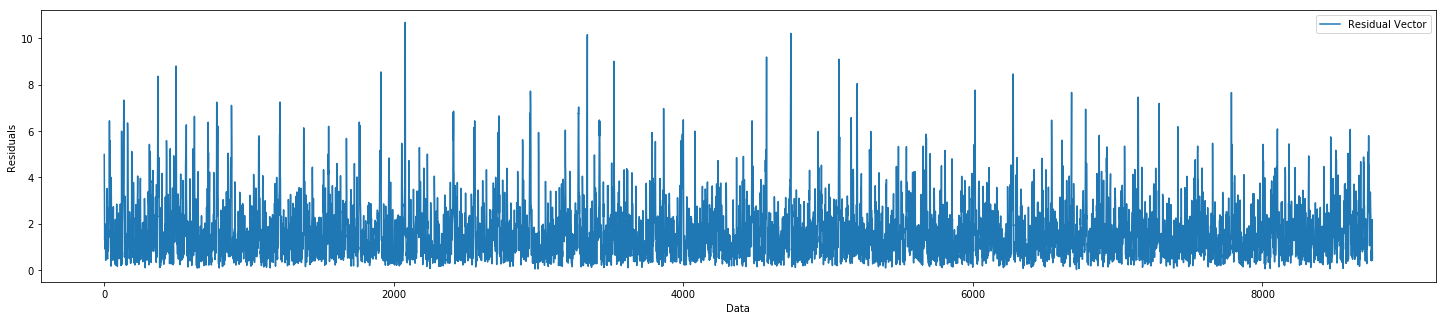

In [7]:
#function that computes the residuals 
res = compute_residuals(n_data, rec_data)

# Plot the residuals vector to check for abnormalities 
plt.figure(figsize=[25,5])
plt.xlabel("Data")
plt.ylabel("Residuals")
plt.plot(res,label= 'Residual Vector')
plt.legend(loc= 'upper right')

- The figure above shows that there are abnormalities in the train data; there are some large spikes that they do not follow the normal distribution of the signal. We removed the outliers based on an outlier threshold.

In [8]:
# new train_data and labels 
lb= y1[res<=5] 
t_data = X1[res<= 5] 

#print the new shape
print("Cleaned Data new shape:",t_data.shape)

Cleaned Data new shape: (8572, 40)


- Apply the same model to the new train data.

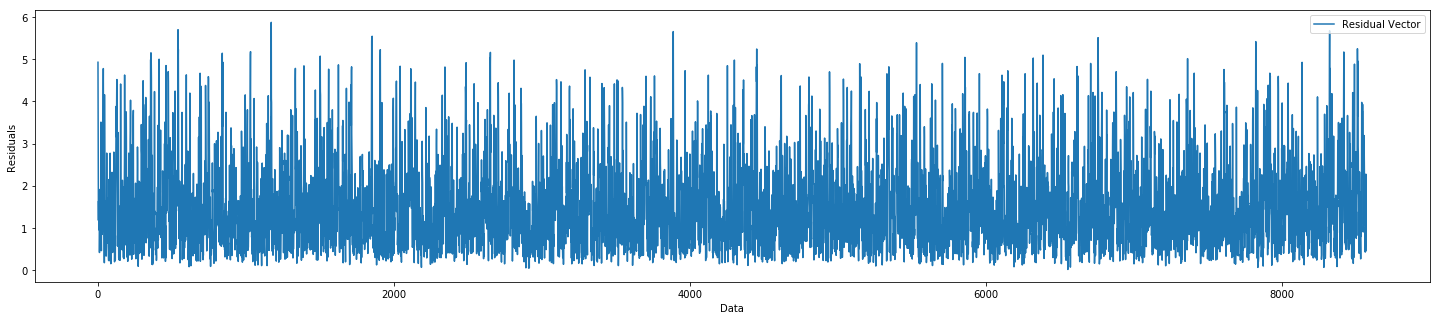

In [9]:
norm = StandardScaler()
norm_t_data = norm.fit_transform(t_data)

p_t_data = pca.fit_transform(norm_t_data)
rec_t_data = pca.inverse_transform(p_t_data)

res_t = compute_residuals(norm_t_data, rec_t_data)

# Plot the residuals vector 
plt.figure(figsize=[25,5])
plt.xlabel("Data")
plt.ylabel("Residuals")
plt.plot(res_t,label= 'Residual Vector')
plt.legend(loc='upper right')

### Find the optimal threshold that produces the least number of false positives
- We computed the threshold according to the paper "Diagnosing Network-Wide Traffic Anomalies" by et al. Lakhina. The threshold is obtained using the Q-Statistic function.

1.4839101972797561


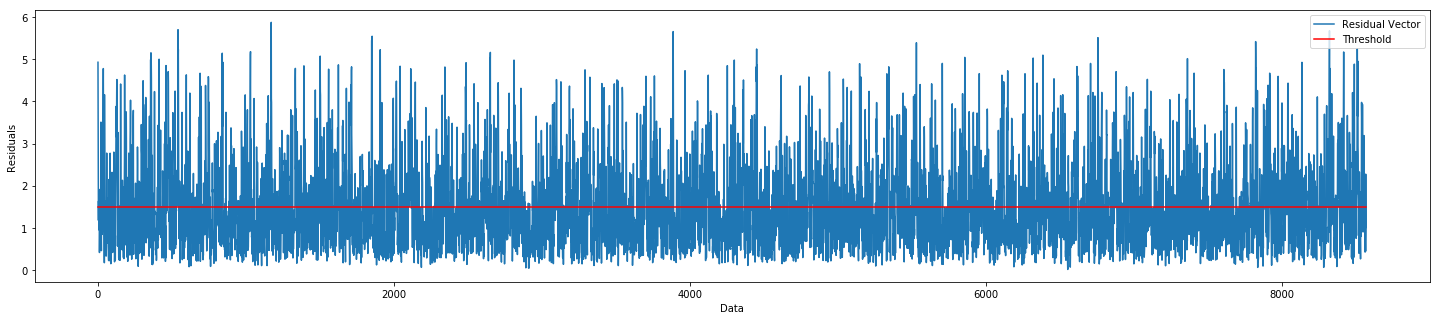

In [10]:
# Q_stat function computes the threshold using Q_statistic function 
threshold =  Q_stat(model, num)
print(threshold)
 
# visualize the new threshold and the threshold obtained from the Q_stat
plt.figure(figsize=[25,5])
plt.xlabel("Data")
plt.ylabel("Residuals")
plt.plot(res_t, label ='Residual Vector')
plt.plot([0,len(res_t)],[threshold, threshold],'r', label = 'Threshold' )
plt.legend(loc= 'upper right')



- As can it be seen in the figure above the threshold that was obtained by the Q_stat function is not optimal. Therefore, we decided to use our threshold that will result in a low number of false positive in the train set.

In [11]:
#test different number of threshold, where new_threshold > threshold obtained from the q stat.
thresholds = [5.2,5.3,5.4,5.5,5.6,5.7]
FP = np.zeros(len(thresholds))
for i in range(len(thresholds)):
    predict =  res_t > thresholds[i] 
    conf = estimate_confusion_matrix(lb, predict)
    FP[i] = conf[0,1]
#     print("Threshold:", i , "results to the following confusion matrix")
print(FP)


[13.  9.  8.  6.  4.  1.]


- As we can see from the FP on the train data, if we set the threshold above 5.7, the number of FP will be 1 and then 0. We need the limit to result in a low number of FP, therefore we chose to use 5.6.

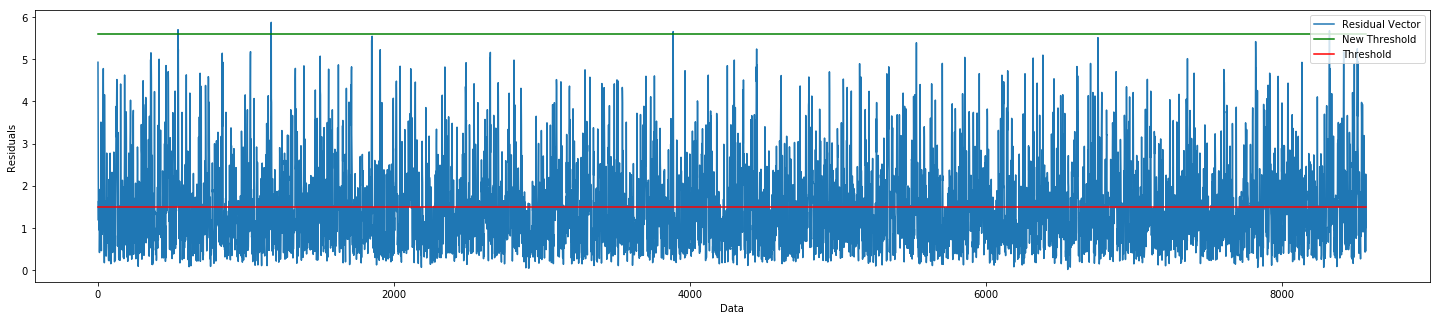

In [12]:
#new threshold we chose to use. 
new_threshold = 5.6

# visualize the new threshold and the threshold obtained from the Q_stat
plt.figure(figsize=[25,5])
plt.xlabel("Data")
plt.ylabel("Residuals")
plt.plot(res_t, label='Residual Vector')
plt.plot([0,len(res_t)],[new_threshold, new_threshold],'g', label = 'New Threshold' )
plt.plot([0,len(res_t)],[threshold, threshold],'r', label = 'Threshold' )
plt.legend(loc='upper right')


### Results of the new train data
- We used the method provided by "Diagnosing Network-Wide Traffic Anomalies" by et al. Lakhina. They considered that if the Squared Prediction Error is above a threshold, this would be an anomaly. 
- We printed the results for both thresholds.

In [13]:
#detect anomalies the fuction returns the predicted labels where spe>threshold
scale= StandardScaler()
att_data = scale.fit_transform(X2)
predicted_labels = det_anomalies(norm_t_data, att_data, num, threshold)

Confusion Matrix: 
 [[ 465 2375]
 [  27 1310]] 

Accuracy: 0.425
Precision: 0.164
Recall: 0.945
F_score: 0.279
Score : 0.654


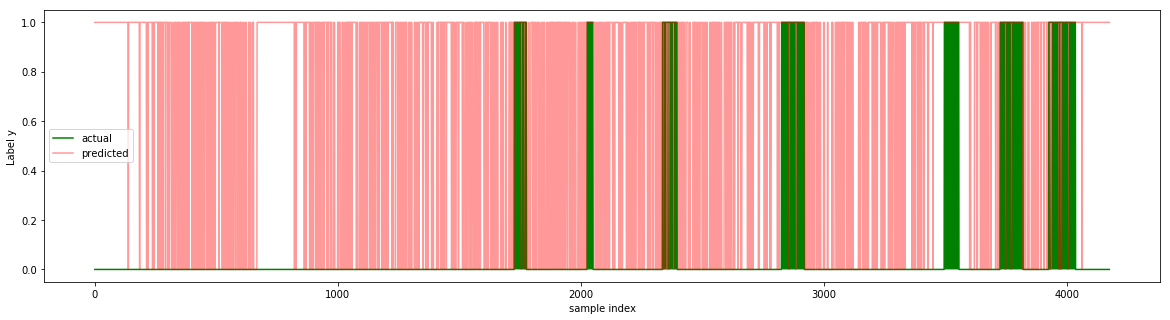

In [15]:
#print results for the first dataset
cm = estimate_confusion_matrix(y2, predicted_labels)
accuracy, precision, recall, F1_score = performance_metrics(cm)
c = compute_s(y2, predicted_labels, 0.01)
    
print ("Confusion Matrix: \n", cm,"\n")
print("Accuracy: %.3f" %accuracy)
print("Precision: %.3f" % precision)
print("Recall: %.3f" %recall)
print("F_score: %.3f" % F1_score)
print("Score : %.3f"%c)

# Visualize the predicted vs the true labels
plot(y2, predicted_labels)

Confusion Matrix: 
 [[ 139   99]
 [ 353 3586]] 

Accuracy: 0.892
Precision: 0.584
Recall: 0.283
F_score: 0.381
Score : 0.631


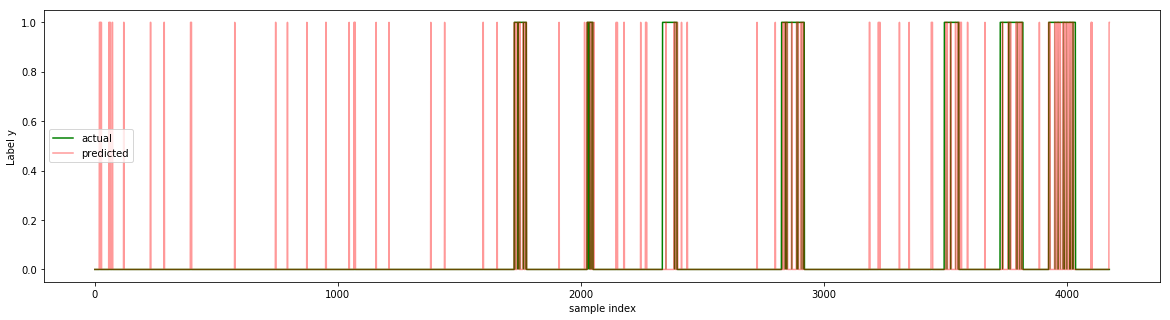

In [17]:
#detect again with the new threshold
predicted_labels2 = det_anomalies(norm_t_data,att_data, num, new_threshold)
cm1 = estimate_confusion_matrix(y2, predicted_labels2)
accuracy1, precision1, recall1, F1_score1 = performance_metrics(cm1)
c_2 = compute_s(y2, predicted_labels2, 0.01)

print ("Confusion Matrix: \n", cm1, '\n')
print("Accuracy: %.3f" %accuracy1)
print("Precision: %.3f" % precision1)
print("Recall: %.3f" %recall1)
print("F_score: %.3f" % F1_score1)
print("Score : %.3f"%c_2)

# Visualize the predicted vs the true labels
plot(y2, predicted_labels2)

### Results of the train data without deleting the outliers.

Confusion Matrix: 
 [[ 462 2373]
 [  30 1312]] 

Accuracy: 0.425
Precision: 0.163
Recall: 0.939
F_score: 0.278
Score : 0.651


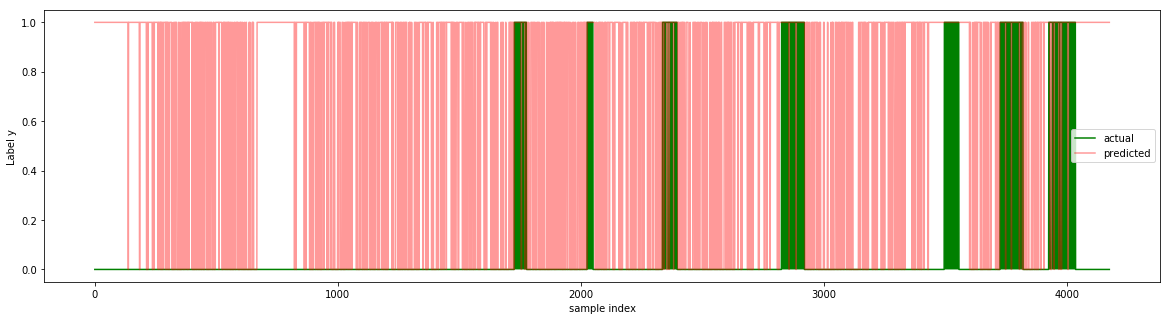

In [18]:
#detect again with the threshold provided by q_stat on the original data
predicted_labels3 = det_anomalies(n_data,att_data, num, threshold)
cm2 = estimate_confusion_matrix(y2, predicted_labels3)
accuracy2, precision2, recall2, F1_score2 = performance_metrics(cm2)
c_3 = compute_s(y2, predicted_labels3, 0.01)

print ("Confusion Matrix: \n", cm2,'\n')
print("Accuracy: %.3f" %accuracy2)
print("Precision: %.3f" % precision2)
print("Recall: %.3f" %recall2)
print("F_score: %.3f" % F1_score2)
print("Score : %.3f"%c_3)

# Visualize the predicted vs the true labels
plot(y2, predicted_labels3)

- Again we have to tune the threshold to result to a low number of false positives in the train set.

In [19]:
#test different number of threshold, where new_threshold > threshold obtained from the q stat.
thresholds1 = [9.1,9.2,9.3,9.4,9.5]

FP1 = np.zeros(len(thresholds1))
for i in range(len(thresholds1)):
    predict2 =  res > thresholds1[i] 
    conf2 = estimate_confusion_matrix(y1, predict2)
    FP1[i] = conf2[0,1]
print(FP1)

[4. 3. 3. 3. 3.]


Confusion Matrix:
 [[  39    6]
 [ 453 3679]] 

Accuracy: 0.890
Precision: 0.867
Recall: 0.079
F_score: 0.145
Score : 0.540


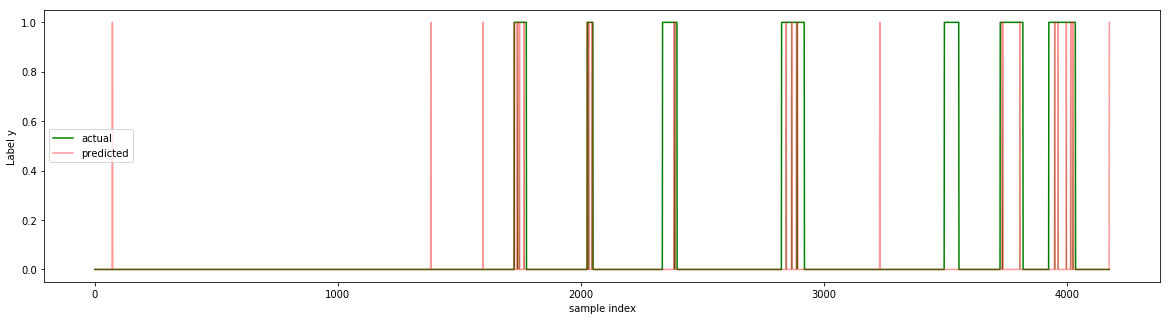

In [20]:
#detect again with the the new threhold on the original data
thres =9.1
predicted_labels4 = det_anomalies(n_data,att_data, num, thres)
cm3 = estimate_confusion_matrix(y2, predicted_labels4)
accuracy3, precision3, recall3, F1_score3 = performance_metrics(cm3)
c_4 = compute_s(y2, predicted_labels4, 0.01)

print ("Confusion Matrix:\n", cm3,'\n')
print("Accuracy: %.3f" %accuracy3)
print("Precision: %.3f" % precision3)
print("Recall: %.3f" %recall3)
print("F_score: %.3f" % F1_score3)
print("Score : %.3f"%c_4)

# Visualize the predicted vs the true labels
plot(y2, predicted_labels4)